In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import optuna
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

In [2]:
import sys
sys.path.append('../scr')

from utils_clean import filtrar_ub_mensual, partir_train_test
from utils_data import downloadTable
from utils_model import buscar_hiperparametros_arima_sarima
from utils_metrics import errorMetrics

# Importar datos

In [3]:
df = pd.read_csv("W:/repo/Price_prediction/bigqueryDatabases/prices.csv")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'W:/repo/Price_prediction/bigqueryDatabases/prices.csv'

# Limpieza

In [4]:
df = filtrar_ub_mensual(df)

In [5]:
df

year_month
2007-01-01     9.198165
2007-02-01     9.286962
2007-03-01     9.051190
2007-04-01     9.273183
2007-05-01     9.060988
                ...    
2025-01-01    14.121816
2025-02-01    13.820212
2025-03-01    13.902885
2025-04-01    14.183055
2025-05-01    13.517076
Name: price, Length: 221, dtype: float64

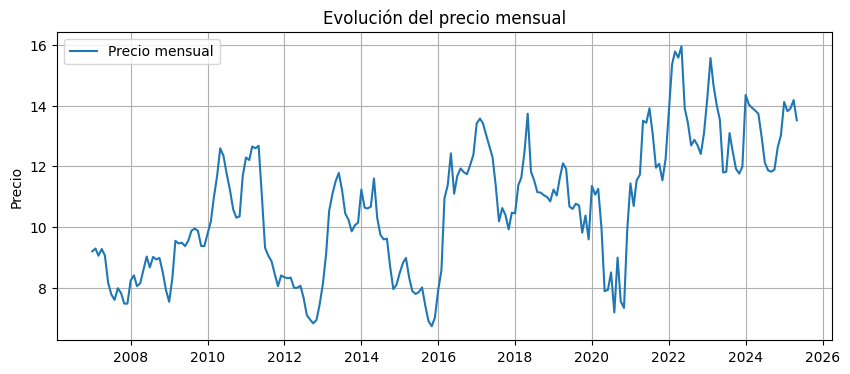

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(df, label="Precio mensual")
plt.title("Evolución del precio mensual")
plt.ylabel("Precio")
plt.grid(True)
plt.legend()
plt.show()

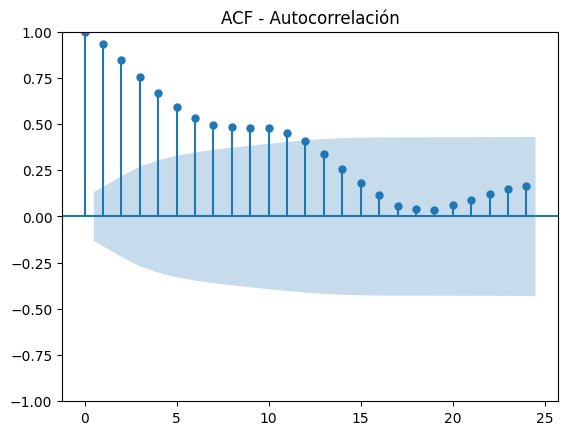

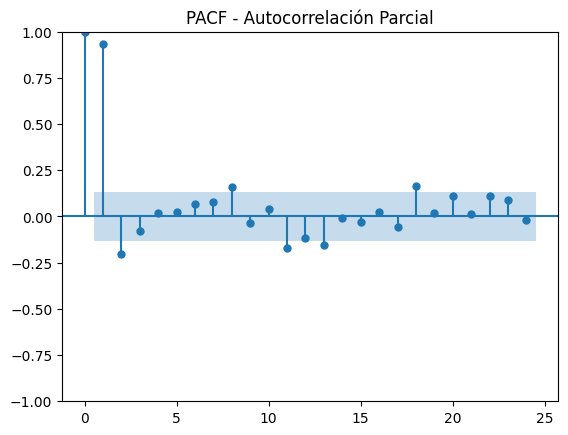

In [7]:

plot_acf(df, lags=24)
plt.title("ACF - Autocorrelación")
plt.show()

plot_pacf(df, lags=24)
plt.title("PACF - Autocorrelación Parcial")
plt.show()


In [8]:

resultado = adfuller(df)
valor_p = resultado[1]
print(f"p: {valor_p}")

# Interpretar el resultado
if valor_p < 0.05:
    print("La serie es estacionaria (se rechaza la hipótesis nula).")
else:
    print("La serie no es estacionaria (no se puede rechazar la hipótesis nula).")

# Como es estacionaria, no es necesario diferenciarla

p: 0.042205261601966436
La serie es estacionaria (se rechaza la hipótesis nula).


# Modelado

## Train test

In [ ]:

df = df.sort_index()
# Entrenamiento: todo hasta diciembre 2024
train = df.loc[:'2024-12-01']   # Ajusta el string según tu índice
# Test: enero, febrero, marzo 2025
test = df.loc['2025-01-01':'2025-03-01']


## Ajuste

In [10]:
modelo, order, seasonal_order, resumen = buscar_hiperparametros_arima_sarima(train, m=12, seasonal=True)
print(resumen)
print("Mejores (p, d, q):", order)
print("Mejores (P, D, Q, m):", seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=488.298, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=480.385, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=481.518, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=486.420, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=484.282, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=480.048, Time=0.25 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=457.866, Time=1.06 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=456.862, Time=1.10 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=482.555, Time=0.28 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=481.220, Time=0.12 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=456.070, Time=0.81 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=485.050, Time=0.23 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AI

In [13]:
order

(0, 1, 0)

## Rolling forecast ARIMA

In [19]:
serie_rolling = train.copy()
predicciones = []
fechas_pred = pd.date_range('2025-01-01', '2025-12-01', freq='MS')

for fecha in fechas_pred:
    modelo = ARIMA(serie_rolling, order=order)
    fitted = modelo.fit()
    pred = fitted.forecast(steps=1)[0]
    predicciones.append(pred)
    
    # Rolling: Si hay valor real, lo uso; si no, uso lo predicho
    if fecha in df.index:  # Hay valor real disponible (enero a mayo 2025)
        valor_a_agregar = df.loc[fecha]
    else:  # De junio a diciembre, ya no hay real
        valor_a_agregar = pred
    
    # Concatenar el valor (como pd.Series, con índice fecha)
    serie_rolling = pd.concat([serie_rolling, pd.Series([valor_a_agregar], index=[fecha])])


# Crea una lista de reales solo para las fechas disponibles
reales_disponibles = [df[fecha] if fecha in df.index else np.nan for fecha in fechas_pred]
pred_df = pd.DataFrame({'real': reales_disponibles, 'predicho': predicciones}, index=fechas_pred)
print(pred_df)

                 real   predicho
2025-01-01  14.121816  13.019506
2025-02-01  13.820212  14.121816
2025-03-01  13.902885  13.820212
2025-04-01  14.183055  13.902885
2025-05-01  13.517076  14.183055
2025-06-01        NaN  13.517076
2025-07-01        NaN  13.517076
2025-08-01        NaN  13.517076
2025-09-01        NaN  13.517076
2025-10-01        NaN  13.517076
2025-11-01        NaN  13.517076
2025-12-01        NaN  13.517076


# Evaluación

In [23]:
# Añade año y cuartil (trimestre)
pred_df['año'] = pred_df.index.year
pred_df['cuartil'] = pred_df.index.quarter
pred_df['cuartil_str'] = pred_df['año'].astype(str) + '-Q' + pred_df['cuartil'].astype(str)

# Calcula métricas para cada cuartil con datos reales
for cuartil in pred_df['cuartil_str'].unique():
    datos = pred_df[pred_df['cuartil_str'] == cuartil]
    mask = ~datos['real'].isna()  # Solo evalúa donde hay datos reales
    if mask.sum() > 0:
        metrics = errorMetrics(datos.loc[mask, 'real'], datos.loc[mask, 'predicho'])
        print(f"{cuartil}: {metrics}")
    else:
        print(f"{cuartil}: Sin datos reales para evaluar.")

2025-Q1: {'mse': 0.4376291114538397, 'mae': 0.4955291712962957, 'rmse': 0.6615354196517672, 'mape': 0.03527571409181827}
2025-Q2: {'mse': 0.26101172933273287, 'mae': 0.47307470833333554, 'rmse': 0.5108930703510597, 'mape': 0.034511669474770364}
2025-Q3: Sin datos reales para evaluar.
2025-Q4: Sin datos reales para evaluar.
